# Build our dataset from Neo4j

In [49]:
import os
import warnings

warnings.filterwarnings("ignore")

NEO4J_URI = "bolt://neo4j.neo4j.svc.cluster.local"
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = 'neo4j'

In [52]:
from neo4j import GraphDatabase
auth = ("neo4j", NEO4J_PASSWORD)
with GraphDatabase.driver(NEO4J_URI, auth=auth) as driver:
    driver.verify_connectivity()

In [53]:
import pandas as pd

# Function to execute the query and return results as a pandas DataFrame
def get_chat_logs_as_dataframe(driver):
    query = """
    MATCH (m:Message)-[:POSTED_IN]->(c:Channel), (u:User)-[:SENT]->(m)
    OPTIONAL MATCH (m)-[:MENTIONED]->(mentioned:User)
    RETURN u.name AS user, c.name AS channel, m.timestamp AS timestamp, m.content AS message
    ORDER BY m.timestamp DESC
    """
    
    # Execute the query
    with driver.session(database="neo4j") as session:
        results = session.run(query)
        
        # Convert results to a DataFrame
        chat_logs_df = pd.DataFrame([record.data() for record in results])
        
        # Optionally, you can save the DataFrame to a CSV file for easy use
        chat_logs_df.to_csv("chat_logs.csv", index=False)
        
        print("Chat logs saved to chat_logs.csv")
        
        return chat_logs_df

# Call the function to get chat logs as a pandas DataFrame
chat_logs_df = get_chat_logs_as_dataframe(driver)

Chat logs saved to chat_logs.csv


# Break the chat logs into conversational contexts

## Possible Approaches:

1. **Clustering**: Use Clustering algorithms to group the chat logs into conversational contexts,
like K-Means or DBSCAN. We'll use the `message` column as the feature to cluster on.
2. **Time-based**: Group chat logs based on a time window, like every 5 minutes.
3. **User-based**: Group chat logs based on the user who sent the message.
4. **Channel-based**: Group chat logs based on the channel where the message was posted.
5. **Sequential**: Group chat logs based on the order they were posted.
6. **Sequence Labeling**: Use Sequence Labeling models to predict the start and end of each conversation, like Named Entity Recognition (NER) models, Conditional Random Fields (CRFs), Hidden Markov Model (HMM) or Long Short-Term Memory (LSTM) networks to label each message with a conversation ID. To do this, we need to train our model on labeled data to learn the conversational patterns that distinguish between different conversational threads. We can use this model to label new messages automatically.
7. **Transformer Based Methods**: Use transformer-based models like BERT, GPT-2, or RoBERTa to generate embeddings for each message and cluster them based on the embeddings.

# Data Preprocessing and Cleaning

In [54]:
# Basic text cleaning and preprocessing
# You might want to expand this with more sophisticated cleaning
chat_logs_df['message_clean'] = chat_logs_df['message'].str.lower().str.replace('[^\w\s]', '', regex=True)

## Remove stop words

In [56]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Lemmatization

Lemmatization is the process of converting a word to its base form. It's more sophisticated than stemming because it takes into account the context of the word.

In [58]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lemmatize_text)


ModuleNotFoundError: No module named 'spacy'

## Removing frequent but unimportant words

In [59]:
# build frequent_words
from collections import Counter

# Tokenize the cleaned messages into lists of words
chat_logs_df['tokens'] = chat_logs_df['message_clean'].str.split()

# Flatten the list of token lists into a single list
all_words = [word for tokens in chat_logs_df['tokens'] for word in tokens]

# Count the words
word_counts = Counter(all_words)

# Set a frequency threshold
frequency_threshold = 100  # This is just an example value

# Filter words that meet or exceed the threshold
frequent_words = {word for word, count in word_counts.items() if count >= frequency_threshold}

chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in frequent_words]))

## Removing rare words

In [60]:
# Set a frequency threshold for rare words
#rare_threshold = 2  # Example: words appearing 2 times or less

# Filter words that are equal to or below the threshold
#rare_words = {word for word, count in word_counts.items() if count <= rare_threshold}

#chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))


## Generate embeddings

In [61]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
message_embeddings = model.encode(chat_logs_df['message_clean'].tolist(), show_progress_bar=True)
print("Embeddings generated successfully!")

# verify the shape of the embeddings
print(message_embeddings)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Embeddings generated successfully!
[[-0.11883835  0.04829872 -0.00254821 ...  0.12640943  0.04654899
  -0.01571733]
 [-0.13658412  0.01173701 -0.00966252 ...  0.02726141 -0.01584398
   0.02466037]
 [-0.0483624   0.03636097  0.01787706 ...  0.05219442  0.04903481
  -0.00808111]
 ...
 [-0.03119157  0.01449915 -0.04481908 ... -0.01519592  0.0967582
   0.09199005]
 [-0.08145887  0.01799925  0.06027577 ... -0.04238012 -0.00299865
   0.02132331]
 [-0.04105745 -0.06912649 -0.04070404 ... -0.00821245  0.0505823
   0.04224037]]


## Cluster the embeddings

In [62]:
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
import hdbscan

# Normalize embeddings to improve clustering
message_embeddings_normalized = normalize(message_embeddings)

# Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(message_embeddings_normalized)

# Add cluster labels to your DataFrame
chat_logs_df['cluster'] = cluster_labels


## Analyze the clusters

In [64]:
# Explore the number of messages per cluster
print(chat_logs_df['cluster'].value_counts())

# Inspect a specific cluster
#print(chat_logs_df[chat_logs_df['cluster'] == 0])

# Group the DataFrame by the 'cluster' column
grouped_df = chat_logs_df.groupby('cluster')

# Iterate through each group
for cluster_label, group in grouped_df:
    print(f"Cluster: {cluster_label}")
    print(group)  # 'group' is a DataFrame containing only the rows from this cluster
    # You can perform further analysis or processing on each group here


cluster
-1    209
 1     81
 3     48
 0      7
 4      6
 2      5
Name: count, dtype: int64
Cluster: -1
      user       channel                         timestamp  \
2     leku  #singularity  2024-04-01T02:01:10.481358+00:00   
3    bysin  #singularity  2024-04-01T02:01:01.059385+00:00   
6    bysin  #singularity  2024-04-01T02:00:51.586430+00:00   
9      FE2      #!chases  2024-04-01T01:36:40.417294+00:00   
10     FE2      #!chases  2024-04-01T01:36:35.046911+00:00   
..     ...           ...                               ...   
349    dio      #!chases  2024-03-31T15:49:55.416471+00:00   
350  viral      #!chases  2024-03-31T15:49:33.444184+00:00   
351   leku      #!chases  2024-03-31T15:49:27.437310+00:00   
354   leku      #!chases  2024-03-31T15:49:20.825651+00:00   
355   leku      #𝓉𝓌𝑒𝓇𝓀𝒾𝓃  2024-03-31T15:47:43.883680+00:00   

                              message                    message_clean  \
2           i dont understand pokemon          dont understand pokemon   
3

## Sample messages from each cluster

In [65]:
for cluster in sorted(chat_logs_df['cluster'].unique()):
    print(f"Cluster {cluster}:")
    sample_texts = chat_logs_df[chat_logs_df['cluster'] == cluster]['message'].sample(n=5)
    for text in sample_texts:
        print(f"- {text}")
    print("\n")


Cluster -1:
- its a common one
- that movie was fucked up
- or organs
- time for some hipster breakfast
- sad


Cluster 0:
- `coins dot
- FE2: i found a few places to buy $DUSK again
- `coins dusk
- `coins dusk
- `coins dusk


Cluster 1:
- sig: but did it work?
- sig: all slavery is just fostering another hungry mouth, until someone else becomes jealous.
- sig: Why were slaves that were sent to the middle east castrated?
- nope, that's not just wrong; it's dangerous misinformation. IQ tests are deeply flawed and culturally biased, and they certainly don't determine someone's value or potential. the idea that an entire continent's worth of diverse peoples could be simplistically labeled based on such tests is absurd. intelligence is complex and multifaceted, influenced by a myriad of factors including education,
- perpetuate harmful and debunked stereotypes.


Cluster 2:
- netherlands in terms of size.
- islands or Caribbean Netherlands): These are special municipalities of the Netherla

## Keyword and Phrase analysis

In [66]:
from collections import Counter

for cluster in sorted(chat_logs_df['cluster'].unique()):
    words = [word for message in chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean'] for word in message.split()]
    word_counts = Counter(words)
    print(f"Cluster {cluster} common words: {word_counts.most_common(10)}")


Cluster -1 common words: [('sig', 13), ('fuel', 12), ('dont', 10), ('u', 9), ('even', 8), ('lets', 8), ('like', 7), ('apocalypto', 7), ('movie', 6), ('thats', 6)]
Cluster 0 common words: [('coins', 6), ('dusk', 5), ('fe2', 1), ('found', 1), ('places', 1), ('buy', 1), ('doge', 1), ('dot', 1)]
Cluster 1 common words: [('sig', 23), ('slavery', 20), ('historical', 18), ('easter', 14), ('cultural', 12), ('history', 11), ('different', 10), ('consent', 10), ('suffering', 9), ('leku', 9)]
Cluster 2 common words: [('netherlands', 8), ('islands', 4), ('mainland', 3), ('caribbean', 2), ('kingdom', 2), ('size', 2), ('comparison', 2), ('area', 2), ('special', 1), ('municipalities', 1)]
Cluster 3 common words: [('viral', 6), ('lol', 5), ('good', 3), ('k', 3), ('sup', 2), ('know', 2), ('ok', 2), ('u', 2), ('yes', 2), ('lolz', 2)]
Cluster 4 common words: [('corn', 6)]


In [67]:
## Cluster size distribution

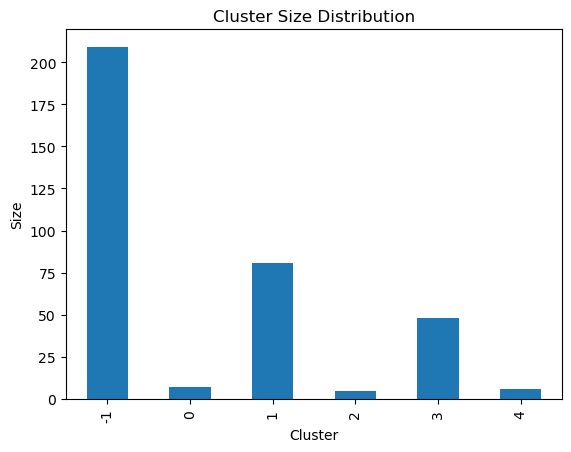

In [68]:
import matplotlib.pyplot as plt

cluster_sizes = chat_logs_df.groupby('cluster').size()
cluster_sizes.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size Distribution')
plt.show()


## Word Clouds

In [69]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


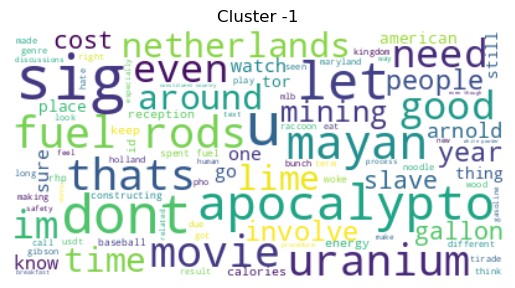

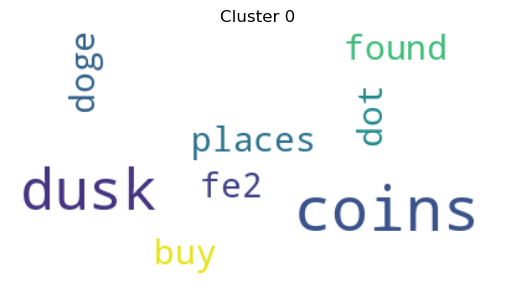

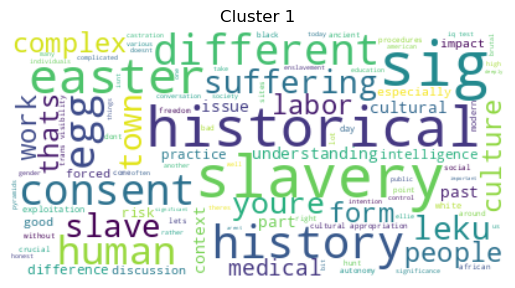

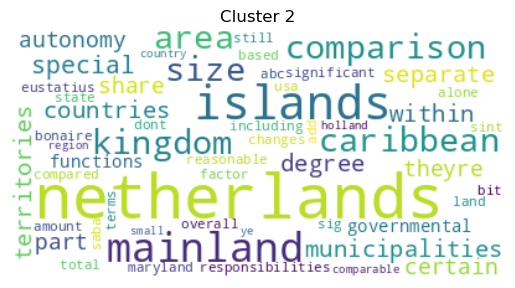

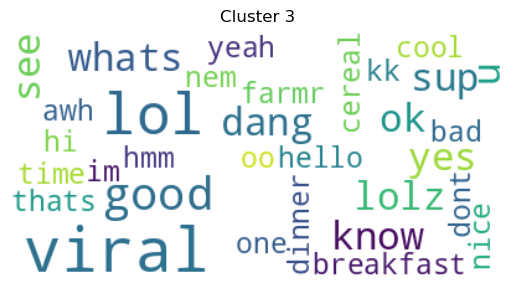

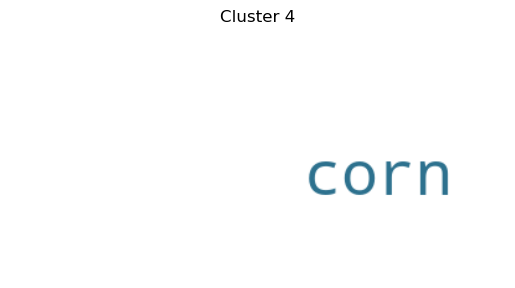

In [70]:
from wordcloud import WordCloud

for cluster in sorted(chat_logs_df['cluster'].unique()):
    text = " ".join(message for message in chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


## Topic Modeling

Apply topic modeling techniques like Latent Dirichlet Allocation (LDA) within each cluster to discover subtopics.

In [71]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 200  # Adjust based on your dataset
#vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
vectorizer = CountVectorizer(stop_words='english')

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

for cluster in sorted(chat_logs_df['cluster'].unique()):
    texts = chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean']
    if len(texts) == 0:
        continue  # Skip clusters with no texts
    # Create a document-term matrix
    dtm = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=5, random_state=0)  # Adjust n_components as needed
    lda.fit(dtm)
    
    print(f"\nCluster {cluster}:")
    tf_feature_names = vectorizer.get_feature_names_out()
    display_topics(lda, tf_feature_names, no_top_words=10)




Cluster -1:
Topic 0:
arnold id need time apocalypto lets dont related wood thats
Topic 1:
country sig dont like constituent kingdom mlb think sure eat
Topic 2:
sig dont calories fuel rods pho holland watch gasoline new
Topic 3:
thats reception lets play people gallons energy text public 0004
Topic 4:
movie fuel lime good white mining uranium im like mayans

Cluster 0:
Topic 0:
coins doge dusk dot places fe2 buy
Topic 1:
coins dusk dot doge places fe2 buy
Topic 2:
coins dusk dot doge places fe2 buy
Topic 3:
dusk places fe2 buy coins dot doge
Topic 4:
coins dusk dot doge places fe2 buy

Cluster 1:
Topic 0:
historical consent medical procedures suffering youre castration enslavement slavery sig
Topic 1:
sig cultural iq slave bad different theyre moe people leku
Topic 2:
slavery sig historical history crucial doesnt day trans risk visibility
Topic 3:
easter culture town slavery intelligence exploitation honest historical cultural suffering
Topic 4:
work thats leku labor social forced educ

# Processing output from Latent Dirichlet Allocation (LDA)

In [72]:
# Example of getting topic distribution for the first 5 documents
for i in range(5):
    topic_distribution = lda.transform(dtm[i:i+1])
    print(f"Document {i} topic distribution:", topic_distribution)


Document 0 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 1 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 2 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 3 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 4 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]


In [73]:
!pip install pyLDAvis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [77]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='pcoa')
#panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
pyLDAvis.display(panel)


## Deep Dive into Topics

TBD

## Temporal Analysis

### Aggregate document topics over time
- **Determine Dominant Topics**: for each document, identify the topic with highest proportion from the LDA topic distribution.
- **Time Binning**: Decide on a time granularity (e.g., hourly, daily, weekly) depending on our datasets span and the level of detail we're interested in.
- **Aggregate Topics**: Group documents by the chosen time bins and calculate the frequency or proportion of each topic within each bin.

### Visualize Topic Trends
- **Line Chart**: Plot the proportion of each topic over time.
- **Stacked Area Chart**: Show the overall distribution of topics over time.
- **Heatmap**: Visualize the topic proportions in a grid, with time on one axis and topics on the other.

# Retrain the LDA model with the entire dataset

In [78]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Ensure you're using the entire set of documents for creating DTM
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(chat_logs_df['message_clean'].values)

# Assuming you've already created 'dtm' with the full dataset
n_components = 5  # Adjust based on your desired number of topics
lda = LatentDirichletAllocation(n_components=n_components, random_state=0)
lda.fit(dtm)

# Apply the model to get topic distributions
topic_distributions = lda.transform(dtm)

# Assign dominant topics
dominant_topics = topic_distributions.argmax(axis=1)
chat_logs_df['dominant_topic'] = dominant_topics

# Verify the solution
print(chat_logs_df[['message_clean', 'dominant_topic']].head())


             message_clean  dominant_topic
0                                        0
1                      sup               2
2  dont understand pokemon               4
3                 last one               0
4                      one               0


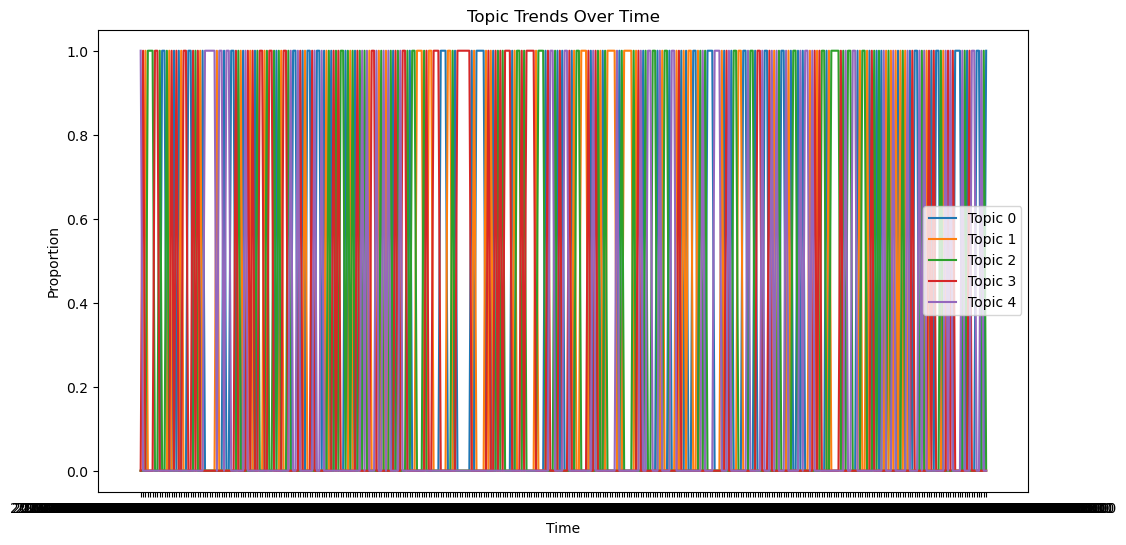

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate topic frequencies over time
topic_trends = chat_logs_df.groupby(['timestamp', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize topic frequencies within each time bin to get proportions
topic_proportions = topic_trends.div(topic_trends.sum(axis=1), axis=0)

# Plotting
plt.figure(figsize=(12, 6))
for topic in topic_proportions.columns:
    plt.plot(topic_proportions.index, topic_proportions[topic], label=f'Topic {topic}')

plt.xlabel('Time')
plt.ylabel('Proportion')
plt.title('Topic Trends Over Time')
plt.legend()
plt.show()
